# Carcrash EDA using GPT to generate insights

## 1. Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import base64

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.max_open_warning': 0})

## 2. Set up OpenAI API key

In [3]:
API_KEY = ''
with open('api_key.txt') as f:
    API_KEY = f.read().strip()
    
import openai
openai.api_key = API_KEY

## 3. Global variables

In [4]:
palette_color = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#34495e', '#f1c40f', '#e67e22', '#95a5a6', '#1abc9c', '#16a085']
font_size = 10

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.dpi'] = 150
background_color='#F5F4EF'

## 4. Loading data and basic validation

In [5]:
carcrash = pd.read_csv('car-crash-dataset/monroe county car crach 2003-2015.csv', encoding='unicode_escape')
display(carcrash.head())

Year  Month  Day Weekend?    Hour Collision Type         Injury Type  \
0  2015      1    5  Weekday     0.0          2-Car   No injury/unknown   
1  2015      1    6  Weekday  1500.0          2-Car   No injury/unknown   
2  2015      1    6  Weekend  2300.0          2-Car  Non-incapacitating   
3  2015      1    7  Weekend   900.0          2-Car  Non-incapacitating   
4  2015      1    7  Weekend  1100.0          2-Car   No injury/unknown   

                          Primary Factor      Reported_Location   Latitude  \
0  OTHER (DRIVER) - EXPLAIN IN NARRATIVE             1ST & FESS  39.159207   
1                  FOLLOWING TOO CLOSELY          2ND & COLLEGE  39.161440   
2              DISREGARD SIGNAL/REG SIGN  BASSWOOD & BLOOMFIELD  39.149780   
3          FAILURE TO YIELD RIGHT OF WAY         GATES & JACOBS  39.165655   
4          FAILURE TO YIELD RIGHT OF WAY                  W 3RD  39.164848   

   Longitude  
0 -86.525874  
1 -86.534848  
2 -86.568890  
3 -86.575956  
4 -86.579625

In [224]:
carcrash.describe()

Year         Month           Day          Hour      Latitude  \
count  53943.000000  53943.000000  53943.000000  53718.000000  53913.000000   
mean    2008.968059      6.662162      4.196912   1347.265349     35.582109   
std        3.789760      3.514630      1.909440    531.654039     11.289883   
min     2003.000000      1.000000      1.000000      0.000000      0.000000   
25%     2006.000000      4.000000      3.000000   1000.000000     39.142048   
50%     2009.000000      7.000000      4.000000   1400.000000     39.164430   
75%     2012.000000     10.000000      6.000000   1700.000000     39.173344   
max     2015.000000     12.000000      7.000000   2300.000000     41.228665   

          Longitude  
count  53913.000000  
mean     -78.619224  
std       24.957587  
min      -88.959213  
25%      -86.551520  
50%      -86.530992  
75%      -86.508288  
max       86.596363

Note that the day is actually the day of the week, not the day of the month. So we are not able to pinpoint the exact date of the accident.

## 5. Some unitility functions to encode the images and pass it to GPT API

In [92]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [114]:
default_prompt = 'You are a data scientist and your job is to interpret a plot of the data and write a short insight from the plot, say something meaningful. Dont just respond theres no trend. Only provide with your description and keep it under 50 words.'

def gpt_plot_description_generator(base64_image, setting_prompt = default_prompt):
    api_key = API_KEY

    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
    }

    payload = {
        'model': "gpt-4-vision-preview",
        'messages': [
            {
            "role": "user",
            "content": [
                {"type": "text", "text": f"{setting_prompt}"},
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                },
                }]
            }
        ],
        "max_tokens": 300
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()['choices'][0]['message']['content']

## 6. Time for Some basic EDA

First generate a basic plot for gpt, then we will use the reponse from gpt and refine our plot.

### 6.1. Yearly trend

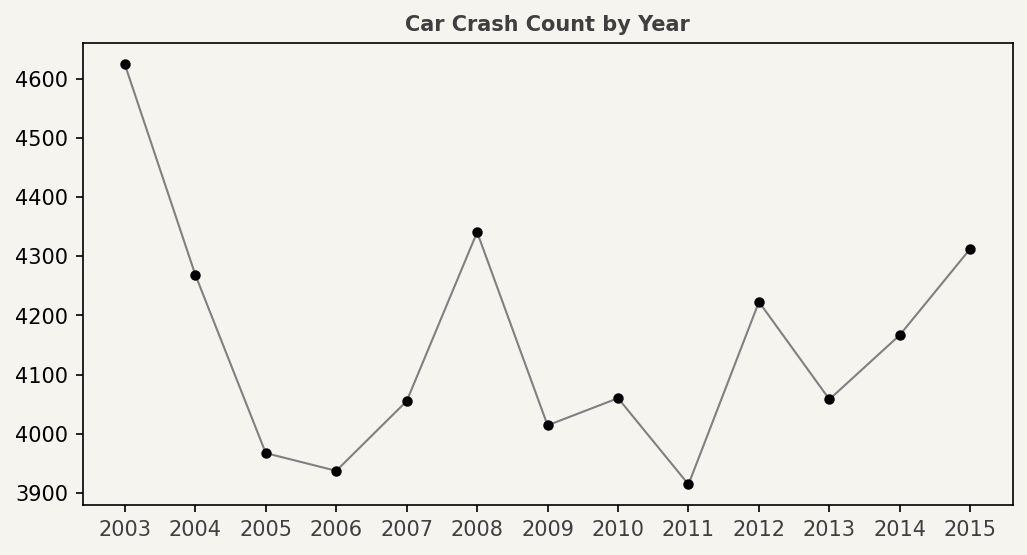

In [123]:
# Data
carcrash_year_cnt = carcrash['Year'].value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(8, 4), facecolor=background_color)
ax.set(facecolor=background_color)

plt.plot(carcrash_year_cnt.index, carcrash_year_cnt.values, color='gray', linestyle='-', linewidth=1, markersize=8)
plt.plot(carcrash_year_cnt.index, carcrash_year_cnt.values, 'o', color='black', markersize=4)

plt.title('Car Crash Count by Year', fontsize=font_size, fontweight='bold', color='#3F3F3F')
# show all xticks
plt.xticks(carcrash_year_cnt.index, fontsize=font_size, color='#3F3F3F')

plt.show()

# save plot
fig.savefig('carcrash_year_cnt.jpeg', bbox_inches='tight', facecolor=background_color)

In [125]:
carcrash_year_cnt_base64_image = encode_image('carcrash_year_cnt.jpeg')
carcrash_year_cnt_description = gpt_plot_description_generator(carcrash_year_cnt_base64_image)
print(carcrash_year_cnt_description)

The data shows significant yearly fluctuations in car crash counts, with a notable dip around 2009 and recent rising trend since 2013.


In [149]:
# Function to add line break for the plot description
def addlinebreak(text, length=60):
    # add line break every 50 characters, dont break words
    addlinebreaktext = ''
    linetext = ''
    for words in text.split(' '):
        if len(linetext + words) > length:
            linetext += '\n'
            addlinebreaktext += linetext
            linetext = ''
        linetext += words + ' '
    addlinebreaktext += linetext 
    return addlinebreaktext

carcrash_year_cnt_description_lb = addlinebreak(carcrash_year_cnt_description)
print(carcrash_year_cnt_description_lb)

The data shows significant yearly fluctuations in car crash 
counts, with a notable dip around 2009 and recent rising 
trend since 2013. 


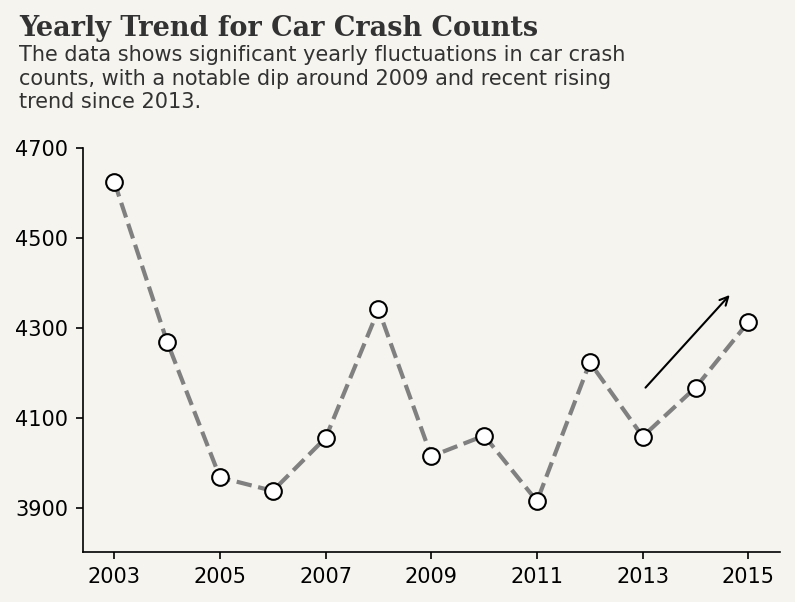

In [290]:
# Data
carcrash_year_cnt = carcrash['Year'].value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(6, 3.5), facecolor=background_color, dpi=150)
ax.set(facecolor=background_color)

plt.plot(carcrash_year_cnt.index, carcrash_year_cnt.values, color='gray', linestyle='dashed', linewidth=2, markersize=8)
plt.plot(carcrash_year_cnt.index, carcrash_year_cnt.values, 'o', color='black', markersize=8)
plt.plot(carcrash_year_cnt.index, carcrash_year_cnt.values, 'o', color='white', markersize=6)

# remove top and right border
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim(3800, 4700)
ax.set_yticks([3900, 4100, 4300, 4500, 4700])
ax.set_xticks(carcrash_year_cnt.index[::2])

# Text
x_start, x_end = ax.get_xlim()
y_start, y_end = ax.get_ylim()

offset = 250
ax.text(x_start - 1.2, y_end + offset, 'Yearly Trend for Car Crash Counts', fontsize=font_size+3, fontweight='bold', fontfamily='serif', color='#323232')
ax.text(x_start - 1.2, y_end + offset - 160, carcrash_year_cnt_description_lb, fontsize=font_size, fontweight='light', fontfamily='sans-serif', color='#323232')

# Arrow
# ax.annotate("", xy=(2005.2, 4100), xytext=(2003.8, 4540), arrowprops=dict(arrowstyle="->"))
# ax.annotate("", xy=(2009.4, 4100), xytext=(2008.65, 4330), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(2014.7, 4380), xytext=(2013, 4160), arrowprops=dict(arrowstyle="->"))


plt.show()

### 6.2. Weekday trend

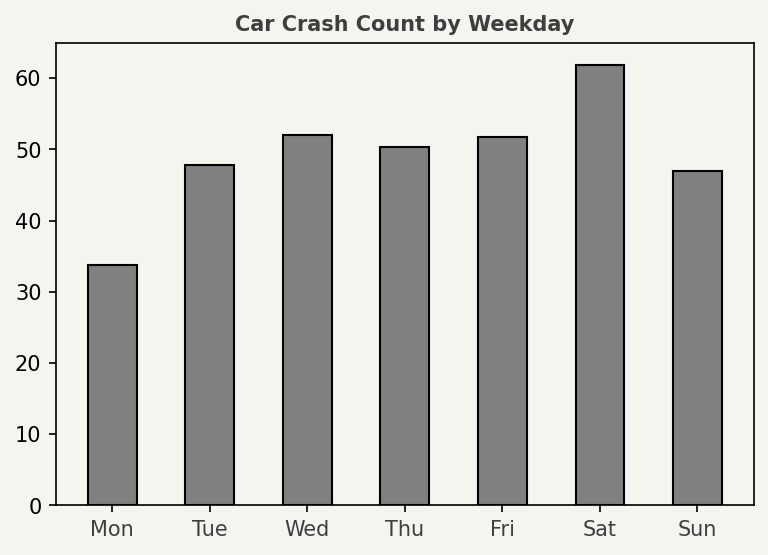

In [311]:
# Data
# carcrash by weekday
carcrash_weekday_cnt = carcrash.groupby(['Year', 'Month', 'Day'])['Hour'].count().reset_index()
carcrash_weekday_cnt = carcrash_weekday_cnt.groupby(['Day'])['Hour'].mean().round(1).sort_index()

# Plot for gpt
fig, ax = plt.subplots(figsize=(6, 4), facecolor=background_color)
ax.set(facecolor=background_color)

plt.bar(carcrash_weekday_cnt.index, carcrash_weekday_cnt.values, color='gray', linewidth=1, edgecolor='black', width=0.5)
ax.set_xticks(carcrash_weekday_cnt.index)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=font_size, color='#3F3F3F')
plt.title('Car Crash Count by Weekday', fontsize=font_size, fontweight='bold', color='#3F3F3F')

plt.show()
fig.savefig('carcrash_weekday_cnt.jpeg', bbox_inches='tight', facecolor=background_color)

In [313]:
# GPT-4 description
carcrash_weekday_cnt_base64_image = encode_image('carcrash_weekday_cnt.jpeg')
carcrash_weekday_cnt_description = gpt_plot_description_generator(carcrash_weekday_cnt_base64_image)
print(carcrash_weekday_cnt_description)

Car crash incidences peak on Saturdays, suggesting potentially higher weekend traffic or riskier driving behaviors.


In [314]:
carcrash_weekday_cnt_description_lb = addlinebreak(carcrash_weekday_cnt_description)
print(carcrash_weekday_cnt_description_lb)

Car crash incidences peak on Saturdays, suggesting 
potentially higher weekend traffic or riskier driving 
behaviors. 


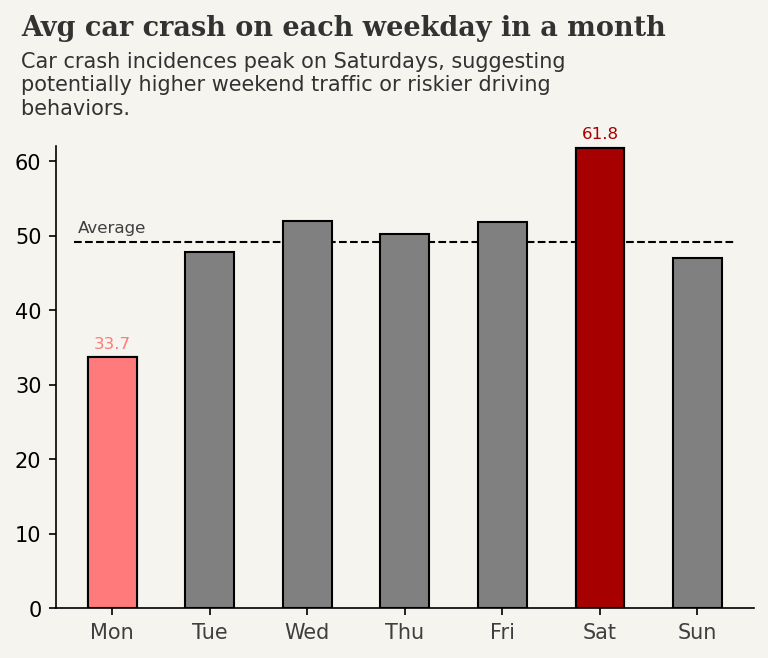

In [372]:
# Data
carcrash_weekday_cnt = carcrash.groupby(['Year', 'Month', 'Day'])['Hour'].count().reset_index()
carcrash_weekday_cnt = carcrash_weekday_cnt.groupby(['Day'])['Hour'].mean().round(1).sort_index()
carcrash_weekday_cnt_avg = carcrash_weekday_cnt.mean()

# Plot with description
fig, ax = plt.subplots(figsize=(6, 4), facecolor=background_color)
ax.set(facecolor=background_color)


plt.bar(carcrash_weekday_cnt.index, carcrash_weekday_cnt.values, color='gray', linewidth=1, edgecolor='black', width=0.5)

ax.set_xticks(carcrash_weekday_cnt.index)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=font_size, color='#3F3F3F')
ax.set_ylim(0, 62)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
# add average line
ax.axhline(carcrash_weekday_cnt_avg, xmin=0.025, xmax=0.975, color='black', linestyle='dashed', linewidth=1, zorder=0)
ax.text(1, carcrash_weekday_cnt_avg + 1.2, 'Average', ha='center', fontsize=font_size-2, color='#3F3F3F')
    
# add number on top of 1st and 6th bar
monday_cnt = carcrash_weekday_cnt.values[0]
saturday_cnt = carcrash_weekday_cnt.values[5]

ax.text(1, monday_cnt + 1.2, monday_cnt, ha='center', fontsize=font_size-2, color='#ff7b7b')
ax.text(6, saturday_cnt + 1.2, saturday_cnt, ha='center', fontsize=font_size-2, color='#a70000')

# change color of the bar for 1st and 6th bar
ax.bar(1, monday_cnt, color='#ff7b7b', linewidth=1, edgecolor='black', width=0.5)
ax.bar(6, saturday_cnt, color='#a70000', linewidth=1, edgecolor='black', width=0.5)

# Text
x_start, x_end = ax.get_xlim()
y_start, y_end = ax.get_ylim()

offset_x = -0.05
offset_y = 0.24
offset_des = -0.17

plt.text(0+offset_x, 1+offset_y, transform=ax.transAxes, s='Avg car crash on each weekday in a month', fontsize=font_size+3, fontweight='bold', fontfamily='serif', color='#323232')
plt.text(0+offset_x, 1+offset_y+offset_des, transform=ax.transAxes, s= carcrash_weekday_cnt_description_lb , fontsize=font_size, fontweight='light', fontfamily='sans-serif', color='#323232')

plt.show()


### 6.3. Monthly trend

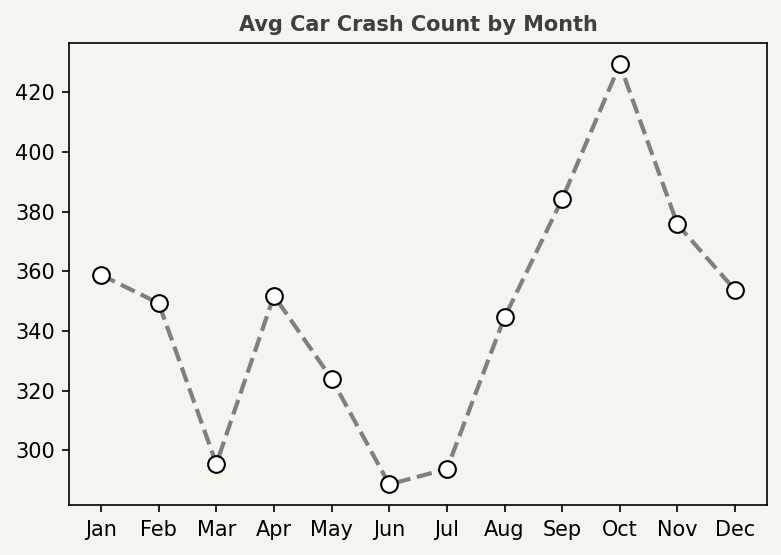

In [370]:
# Data
# carcrash by month
carcrash_month_cnt = carcrash.groupby(['Year', 'Month'])['Day'].count().reset_index()
carcrash_month_cnt = carcrash_month_cnt.groupby(['Month'])['Day'].mean().round(1).sort_index()

# Plot for GPT
fig, ax = plt.subplots(figsize=(6, 4), facecolor=background_color)
ax.set(facecolor=background_color)

plt.plot(carcrash_month_cnt.index, carcrash_month_cnt.values, color='gray', linestyle='dashed', linewidth=2, markersize=8)
plt.plot(carcrash_month_cnt.index, carcrash_month_cnt.values, 'o', color='black', markersize=8)
plt.plot(carcrash_month_cnt.index, carcrash_month_cnt.values, 'o', color='white', markersize=6)


# x axis Jan-Dec
ax.set_xticks(carcrash_month_cnt.index)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 
                    'Nov', 'Dec'], fontfamily='sans-serif', fontsize=font_size)
    
plt.title('Avg Car Crash Count by Month', fontsize=font_size, fontweight='bold', color='#3F3F3F')

plt.show()
fig.savefig('carcrash_month_cnt.jpeg', bbox_inches='tight', facecolor=background_color)
    

In [352]:
# GPT-4 description
carcrash_month_cnt_base64_image = encode_image('carcrash_month_cnt.jpeg')
carcrash_month_cnt_description = gpt_plot_description_generator(carcrash_month_cnt_base64_image)
print(carcrash_month_cnt_description)

Car crash counts peak in October, suggesting a possible seasonal influence on driving safety, with crashes notably decreasing in the following months.


In [353]:
carcrash_month_cnt_description_lb = addlinebreak(carcrash_month_cnt_description)
print(carcrash_month_cnt_description_lb)

Car crash counts peak in October, suggesting a possible 
seasonal influence on driving safety, with crashes notably 
decreasing in the following months. 


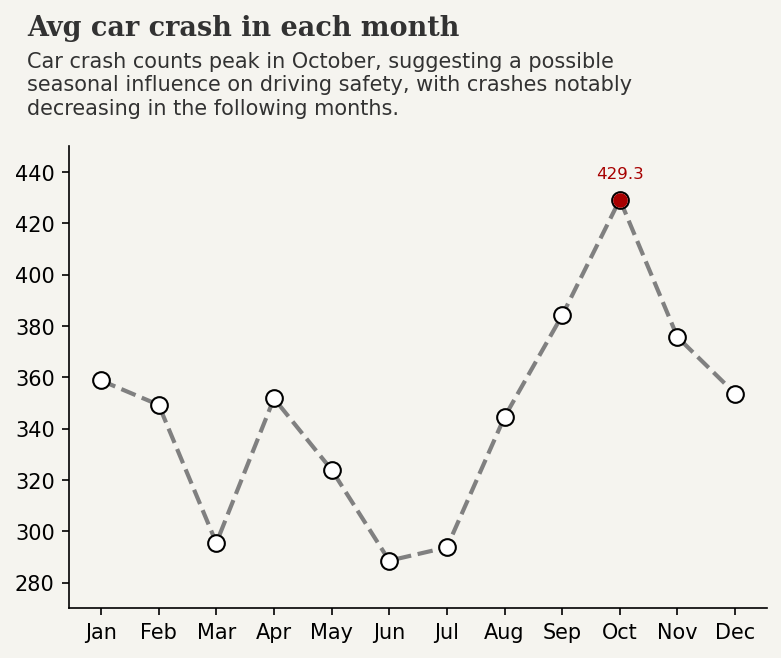

In [368]:
# Data
carcrash_month_cnt = carcrash.groupby(['Year', 'Month'])['Day'].count().reset_index()
carcrash_month_cnt = carcrash_month_cnt.groupby(['Month'])['Day'].mean().round(1).sort_index()

# Plot with description
fig, ax = plt.subplots(figsize=(6, 4), facecolor=background_color)
ax.set(facecolor=background_color)

plt.plot(carcrash_month_cnt.index, carcrash_month_cnt.values, color='gray', linestyle='dashed', linewidth=2, markersize=8)
plt.plot(carcrash_month_cnt.index, carcrash_month_cnt.values, 'o', color='black', markersize=8)
plt.plot(carcrash_month_cnt.index, carcrash_month_cnt.values, 'o', color='white', markersize=6)
plt.ylim(270, 450)

# red dot and text for Oct
oct_value = carcrash_month_cnt.values[9]
plt.plot(10, oct_value, 'o', color='#a70000', markersize=6)
ax.text(10, oct_value + 8, oct_value, ha='center', fontsize=font_size-2, color='#a70000')


# x axis Jan-Dec
ax.set_xticks(carcrash_month_cnt.index)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 
                    'Nov', 'Dec'], fontfamily='sans-serif', fontsize=font_size)
    
# remove top and right border
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
# Text
offset_x = -0.06
offset_y = 0.24
offset_des = -0.17

plt.text(0+offset_x, 1+offset_y, transform=ax.transAxes, s='Avg car crash in each month', fontsize=font_size+3, fontweight='bold', fontfamily='serif', color='#323232')
plt.text(0+offset_x, 1+offset_y+offset_des, transform=ax.transAxes, s=carcrash_month_cnt_description_lb, fontsize=font_size, fontweight='light', fontfamily='sans-serif', color='#323232')

plt.show()
    

## 7. Some plots that haven't finished yet

### 7.1. Monthly trend for each year

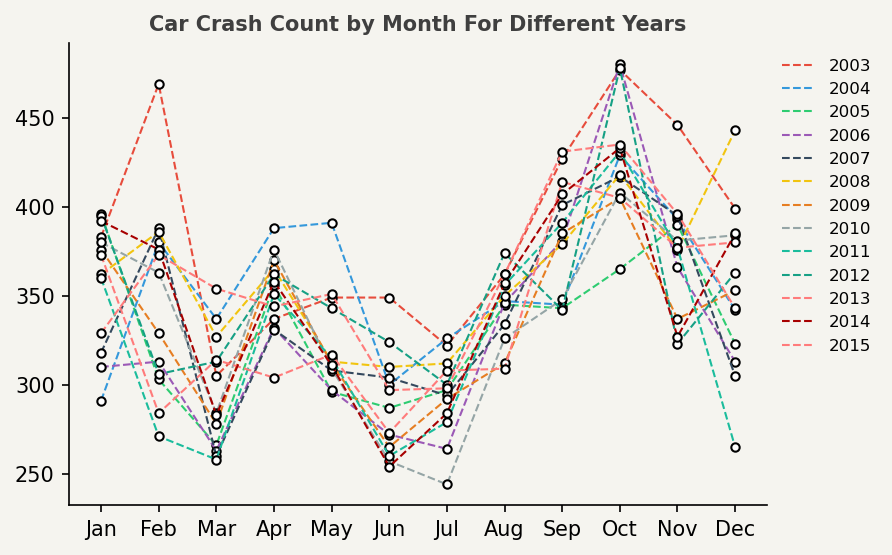

In [380]:
# Data
# carcrash by year-month
import calendar

carcrash_year_month_cnt = carcrash.groupby(['Year', 'Month']).size().reset_index(name='counts')
carcrash_year_month_cnt['Month'] = carcrash_year_month_cnt['Month'].apply(lambda x: calendar.month_abbr[x])

color_palette = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#34495e', '#f1c40f', '#e67e22', '#95a5a6', '#1abc9c', '#16a085', '#ff7b7b', '#a70000','#ff7b7b', '#a70000']

# Plot
fig, ax = plt.subplots(figsize=(6, 4), facecolor=background_color)
ax.set(facecolor=background_color)

for i, year in enumerate(carcrash_year_month_cnt['Year'].unique()):
    temp = carcrash_year_month_cnt[carcrash_year_month_cnt['Year'] == year]
    plt.plot(temp['Month'], temp['counts'], color=color_palette[i], linestyle='dashed', linewidth=1, markersize=8, label=year)
    plt.plot(temp['Month'], temp['counts'], 'o', color='black', markersize=4)
    plt.plot(temp['Month'], temp['counts'], 'o', color='white', markersize=2)
    
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
plt.title('Car Crash Count by Month For Different Years', fontsize=font_size, fontweight='bold', color='#3F3F3F')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=font_size-2)

plt.show()
    

### 7.2. Year-Month trend

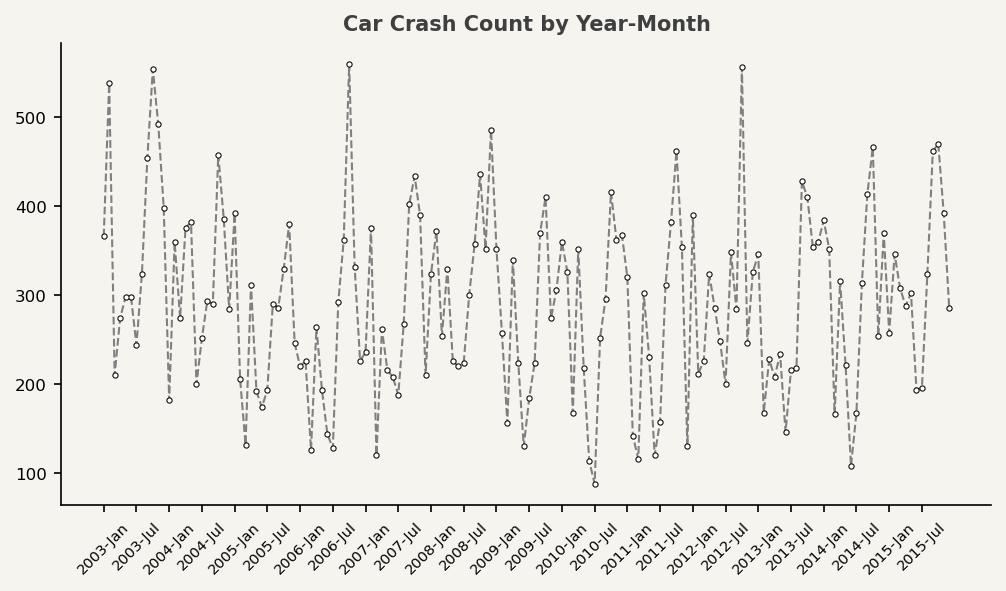

In [335]:
# Data
carcrash_year_month_cnt = carcrash.groupby(['Year', 'Month']).size().reset_index(name='counts')
carcrash_year_month_cnt['Month'] = carcrash_year_month_cnt['Month'].apply(lambda x: calendar.month_abbr[x])
carcrash_year_month_cnt['Year_Month'] = carcrash_year_month_cnt['Year'].astype(str) + '-' + carcrash_year_month_cnt['Month'].astype(str)

# Plot
fig, ax = plt.subplots(figsize=(8, 4), facecolor=background_color)
ax.set(facecolor=background_color)

plt.plot(carcrash_year_month_cnt['Year_Month'], carcrash_year_month_cnt['counts'], color='gray', linestyle='dashed', linewidth=1, markersize=8)
plt.plot(carcrash_year_month_cnt['Year_Month'], carcrash_year_month_cnt['counts'], 'o', color='black', markersize=2)
plt.plot(carcrash_year_month_cnt['Year_Month'], carcrash_year_month_cnt['counts'], 'o', color='white', markersize=1)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
ax.set_xticks(carcrash_year_month_cnt['Year_Month'].iloc[::6])
ax.set_xticklabels(carcrash_year_month_cnt['Year_Month'].iloc[::6], fontfamily='sans-serif', fontsize=font_size-3, rotation=45)
ax.set_yticklabels([0, 100, 200, 300, 400, 500, 600], fontfamily='sans-serif', fontsize=font_size-2)
plt.title('Car Crash Count by Year-Month', fontsize=font_size, fontweight='bold', color='#3F3F3F')

plt.show()


### 7.3. Geographical pattern

In [384]:
# visualize latitudes and longitudes on world map
import plotly.express as px

fig = px.scatter_mapbox(carcrash, lat="Latitude", lon="Longitude", width=800, height=600, opacity=0.5)
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center= dict(lat=39.161030,lon=-86.510924), zoom=9.5))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# lock the plotly plot
fig.show(config={'scrollZoom': False, 'displayModeBar': False, 'editable': False, 'staticPlot': True})


### 7.4. Geographical pattern for each year

In [6]:
# Data
carcrash_animate = carcrash.copy()
carcrash_animate.sort_values(by='Year', inplace=True, ascending=True)

# visualize latitudes and longitudes on world map
import plotly.express as px

fig = px.scatter_mapbox(carcrash_animate, lat="Latitude", lon="Longitude", width=800, height=600, opacity=0.5, animation_frame="Year")
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center= dict(lat=39.161030,lon=-86.510924), zoom=9.5))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.layout.updatemenus = [dict(type='buttons', showactive=False, buttons=[fig.layout.updatemenus[0].buttons[0]])]

# make slider smaller
sliders = [dict(
    pad={"t": 0, "r": 50, "l": 50, "b": 0}
)]

updatemenus = [dict(
    type="buttons",
    direction="left",
    pad={"t": 0, "r": 0, "l": 0, "b": 25},
    showactive=False,
    x=0.12,
    y=-0.04,
    xanchor="right",
)]



fig.update_layout(
    sliders=sliders,
    updatemenus=updatemenus
)

fig.show(config={'scrollZoom': False, 'displayModeBar': False, 'editable': False, 'staticPlot': True})

### 7.5. Car crash heatmap

In [7]:
# Data
carcrash_heatmap = carcrash.copy()

# Plot
fig = px.density_mapbox(carcrash_heatmap, lat='Latitude', lon='Longitude', radius=2, width=800, height=600)
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center= dict(lat=39.161030,lon=-86.510924), zoom=9.5))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show(config={'scrollZoom': False, 'displayModeBar': False, 'editable': False, 'staticPlot': True})

## I'm still working on this notebook, so stay tuned!